In [1]:
from helpers.utilities import (
    DataFrame, Series, partial,
    T, F, pd
)
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

In [3]:
from jupyter_helpers.selective_import import notebooks_importer

In [4]:
from analyses.integration.Uniform_preprocessing import (
    # data matrices
    raw_protein_matrix, raw_rna_matrix,
    clinical_union as clinical,
    # misc
    RNA_OUTLIERS,
    patients_union, patients_union_series, patients_with_both,
    # full response vectors derived from clinical data for
    # the union of patients with CSF RNA or with protein data
    protein_conditions,
    # preprocessing
    preprocess,

    # subsets of patients (uniform train-test split)
    full_cm_and_tmdr,        # CM+TMD+TMR patients with CSF RNA or protein data
    intersect_cm_and_tmdr,   # CM+TMD+TMR patients with both CSF RNA and protein data
    cm_and_tmdr_validation,  # CM+TMD+TMR patients with single omic data only
    tms_validation,          # CM patients with single omic data only + all TMS patients
)

Importing Jupyter notebook from /home/krassowski/meningitis/code/analyses/integration/Uniform_preprocessing.ipynb


For diagnostics:

In [5]:
protein_full = preprocess('protein', 7, None).fit_transform(raw_protein_matrix.T)
rna_full = preprocess('rna', 7, None).fit_transform(raw_rna_matrix.T)

protein_full_groups = protein_full.index.map(clinical.Meningitis_with_tuberculosis_status)

[1] "Retaining: 99.92%"
[1] "Retaining: 52.62%"


### Shared pipeline functions

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from machine_learning.multi_block_pipeline import TwoBlockPipeline, MultiBlockDataSet
from utilities import subset

from machine_learning.repeated_cv import (
    null_distributions_over_cv, cross_validate_and_test
)

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: data.table
 
cvAUC version: 1.1.0
Notice to cvAUC users: Major speed improvements in version 1.1.0
 


Shared plotting functions:

In [7]:
from plots.cm_vs_tmdr_or_tms import cm_vs_tmdr_or_tms_roc_curves

%R import::here(roc_auc_tmdr_cm, .from='plots/cm_vs_tmdr_or_tms.R')
%R import::here(add_linetype_to_ggrepel, .from='plots/roc_auc.R')

In [8]:
cross_validate = partial(
    cross_validate_and_test,
    response=clinical.Meningitis,
    case_class='Tuberculosis',
    use_seed=True,
    multi_scale=True,
    test_size_min=0.16,
    test_size_max=0.33,
    min_class_members=2
)

### OmicsPLS with custom Python wrapper

NIPALS is referred to as "alternative" or "power" method; to use it one should set `p_thresh=1` (so that it is lower than number of features in X) or do an analogous thing with q_thresh. I will use NIPALS as it is much faster implementation (7min vs 1s)

In [9]:
from helpers.pls import format_grid_results
from helpers.o2pls import O2PLS, O2PLSStatistic
from helpers.o2pls import add_grid_metadata, summary_table_for
%R source('thirdparty/OmicsPLS_overrides.R');


Attaching package: ‘OmicsPLS’

The following object is masked from ‘package:stats’:

    loadings



Note: different rules for CV are used in SIMCA, as explained in "Multi- and Megavariate Data Analysis" Appendix II: Statistics, page 462 (Third revised edition). For predictive components threshold of Q2 > 0.01 is required (among other rules), for orthogonal components PCA rules apply.

A set of statistics will be computed during cross validation for every model:

In [10]:
cv_scoring = {
    name: statistic.calc
    for name, statistic in O2PLSStatistic.statistics.items()
}

In [11]:
%%R
import::here(
    grid_search_plot, grid_orthogonal_components_plot,
    .from='plots/omics_o2pls.R'
)

## Using protein scores extracted by O2PLS

In [12]:
def create_o2pls_pipeline(smallest_group_n, outliers, predict, max_components=2, subset=None, verbose=False, n_jobs=None):

    return TwoBlockPipeline(
        x=preprocess('rna', smallest_group_n, outliers),
        y=preprocess('protein', smallest_group_n, outliers),
        model=(
            GridSearchCV(
                O2PLS(max_iterations=500, algorithm='nipals'),
                cv=3,  # repeated?
                iid=True,
                scoring={
                    'average_cv_predictions': cv_scoring['average_cv_predictions']
                },
                refit='average_cv_predictions',
                param_grid=[{
                    # remained: the second is non inclusive
                    'joint_components': range(1, max_components),
                    'x_ortho_components': range(0, max_components),
                    'y_ortho_components': range(0, max_components)
                }],
                verbose=verbose,
                n_jobs=n_jobs
            )
        ),
        predict=predict
    )


def predict_protein_scores(pipeline, dataset, calculate='calculate_Y_scores_U_without_osc'):
    prediction = pipeline.call(
        calculate,
        pipeline.y.transform(dataset.y)
    )
    if len(prediction.columns) != 1:  # for more columns, more advanced technique needed
        print('warning: more latent components chosen!', len(prediction.columns))
    return -prediction[0]


o2pls_pipeline = create_o2pls_pipeline(
    smallest_group_n=7,
    outliers=RNA_OUTLIERS,
    verbose=0,
    max_components=2,
    predict=predict_protein_scores
)

[1] "Retaining: 52.62%"
[1] "Retaining: 99.92%"


In [13]:
def two_blocks_for_integration(rna, protein, patients, outliers, dummy_rna=False):
    b = subset(protein, patients, outliers=outliers)

    return {
        # for o2pls we only validate with protein data as we do not have enough paired observations
        'x': b if dummy_rna else subset(rna, patients, outliers=outliers).loc[b.index],
        'y': b
    }

In [14]:
tms_o2pls_protein_dataset = MultiBlockDataSet(
    two_blocks_for_integration(
        None, raw_protein_matrix,
        patients=tms_validation, outliers=RNA_OUTLIERS,
        dummy_rna=True
    ),
    case_class='Tuberculosis',
    response=clinical.Meningitis
)

OutliersFilter: filtering out 1 outliers


In [15]:
joint_o2pls = cross_validate(
    o2pls_pipeline,
    two_blocks_for_integration(
        raw_rna_matrix, raw_protein_matrix,
        patients=intersect_cm_and_tmdr, outliers=RNA_OUTLIERS
    ),
    test_data=two_blocks_for_integration(
        None, raw_protein_matrix,
        patients=cm_and_tmdr_validation, outliers=RNA_OUTLIERS,
        dummy_rna=True
    ),
    n=100,
    verbose=F,
    stratify=T,
    coefficients={'x': 'W', 'y': 'C'},  # alternatives: _x_coefficients, _y_coefficients
    early_normalization=True
)

OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 0 outliers
OutliersFilter: filtering out 3 outliers


In [16]:
joint_o2pls.pipeline.model.best_estimator_.calc_metrics()

,$R^2X$,$R^2Y$,$R^2X_{hat}$,$R^2Y_{hat}$,$R^2X_{YO}$,$R^2Y_{XO}$,$R^2X_{corr}$,$R^2Y_{corr}$
0,0.046915,0.176504,0.046915,0.176504,0.0,0.0,0.078022,0.293532


Warning: the values below are not Q^2, but R^2 (not what is used to compute them)!

In [17]:
joint_o2pls.pipeline.model.best_estimator_.calc_metrics(
    X=joint_o2pls.pipeline.transformed_blocks['x'],
    Y=joint_o2pls.pipeline.transformed_blocks['y']
)

,$Q^2X_{hat}$,$Q^2Y_{hat}$,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$
0,0.046915,0.176504,0.11171


In [18]:
roc_auc_o2pls = cm_vs_tmdr_or_tms_roc_curves(joint_o2pls, tms_o2pls_protein_dataset)

In [19]:
joint_o2pls.training_dataset.data['x'].head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,...,AL357143.2,MIR7847,MIR6785,MIR4467,AC093390.2
149.TMD,0.0,2.0,17.0,54.99,19.01,...,0.0,0.0,0.0,0.0,0.0
001.TMD,1.0,0.0,0.0,11.00,4.00,...,0.0,0.0,0.0,0.0,1.0
151.TMD,7.0,0.0,43.0,107.18,20.82,...,0.0,0.0,0.0,0.0,0.0
170.TMD,12.0,5.0,36.0,113.13,71.87,...,0.0,0.0,0.0,0.0,4.0
083.TMD,4.0,0.0,46.0,485.06,32.94,...,0.0,0.0,0.0,0.0,0.0


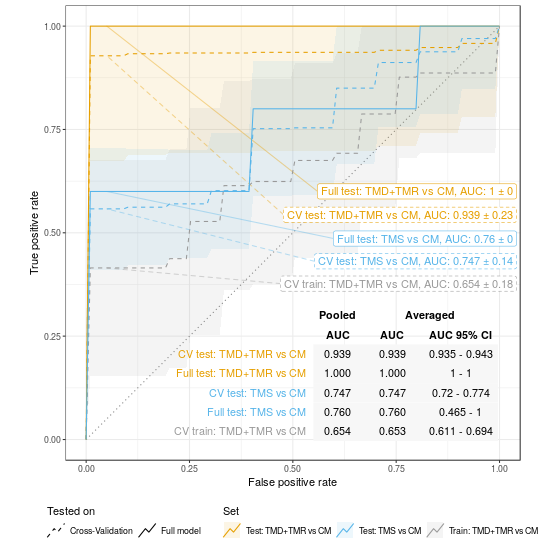

In [20]:
%%R -i roc_auc_o2pls -w 550 -h 550

p = roc_auc_tmdr_cm(roc_auc_o2pls, annotation=0.05)
line_types = c(2, 1, 2, 1, 2, 2)
g = add_linetype_to_ggrepel(ggplotGrob(p), line_types, 'segment')
g = add_linetype_to_ggrepel(g, line_types, 'box')
grid.draw(g)

In [21]:
grid_results = add_grid_metadata(format_grid_results(
    joint_o2pls.cross_validation.estimators[0].model,
    joint_o2pls.cross_validation.estimators[0].transformed_blocks['x']
))

In [22]:
grid_results.head()

,param_joint_components,param_x_ortho_components,param_y_ortho_components,variable,value,...,symbol,joint_mean,mean,std,ortho_gain_percent
0,1.0,0.0,0.0,split0_test_average_cv_predictions,-0.186847,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.183551,-0.142478,0.038470,22.377047
1,1.0,0.0,1.0,split0_test_average_cv_predictions,-0.238205,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.183551,-0.217613,0.021442,-18.557497
2,1.0,1.0,0.0,split0_test_average_cv_predictions,-0.290489,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.183551,-0.211307,0.074074,-15.121609
3,1.0,1.0,1.0,split0_test_average_cv_predictions,-0.218908,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.183551,-0.162806,0.056975,11.302058
4,1.0,0.0,0.0,split1_test_average_cv_predictions,-0.118435,...,$\frac{Q^2X_{hat} + Q^2Y_{hat}}{2}$,-0.183551,-0.142478,0.038470,22.377047


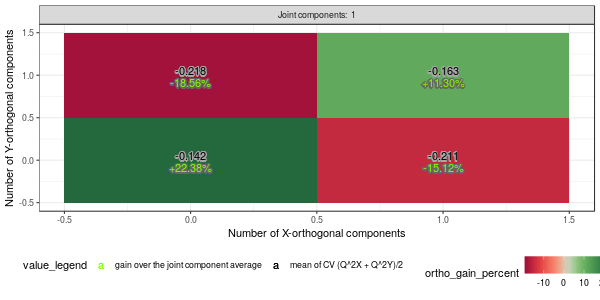

In [23]:
%%R -w 600 -h 300 -i grid_results
grid_orthogonal_components_plot(grid_results)

#### Features driving models with high AUC

In [24]:
joint_o2pls.cross_validation.contributions.x.add_weighted_auc(
    joint_o2pls.sub_sampling_test_results.cv_auc
)
joint_o2pls.cross_validation.contributions.y.add_weighted_auc(
    joint_o2pls.sub_sampling_test_results.cv_auc
)

In [25]:
joint_o2pls_contribs_rna = joint_o2pls.cross_validation.contributions.x.data
joint_o2pls_contribs_protein = joint_o2pls.cross_validation.contributions.y.data

In [26]:
joint_o2pls.cross_validation.contributions.x.add_above_abs_quantile(q=0.5)
joint_o2pls.cross_validation.contributions.y.add_above_abs_quantile(q=0.5)

In [27]:
joint_o2pls.cross_validation.contributions.x.add_above_abs_quantile(q=0.9)
joint_o2pls.cross_validation.contributions.y.add_above_abs_quantile(q=0.9)

In [28]:
%%R
import::here(
    plots_most_frequently_included, plot_most_significant, plot_highest_magnitutude,
    coefficients_volcano_plot, mean_vs_coefficients,
    .from='plots/coefficients.R'
)

[1] "none selected, change frequency threshold"


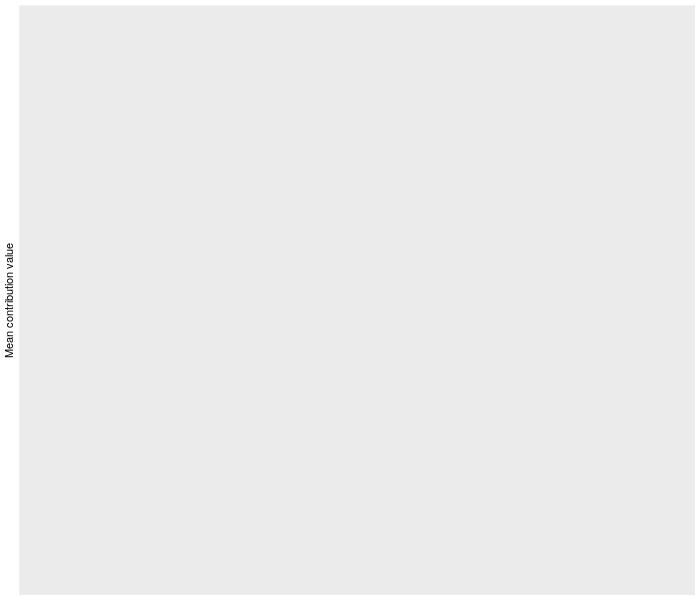

In [29]:
%%R -w 700 -h 600 -i joint_o2pls_contribs_rna
coefficients_volcano_plot(
    joint_o2pls_contribs_rna,
    n=15, p_value='weighted_auc', neg=F,
    quite_stable_alpha=0.3, volatile_alpha=0.1,
    highlight_frequent=0.9, frequency='above_abs_iteration_quantile_0.9',
    frequency_title='Above 0.5 quantile in',
    highlight_top=TRUE
) + ylab('Mean contribution value')

Stable: is stable in over 99% of iterations
Almost stable: is stable in over 90% of iterations (previously termed as "unstable")
Volatile: is stable in less than 90% of iterations.

Highlight: genes with volatile sign were excluded;

top $n$ non-volatile genes with high proportion of contributions to the most successful models were highlighted in the bright red; additionally the genes consistently selected (with value of contribution above median in all iterations) were highlighted in dark red colour (which overrides the bright red if a gene is both in the top and in the most frequently selected subset).

Ideally for comparison with lasso we would say that the protein is selected if it was in top n proteins where n is the average number of coefficients selected by LASSO

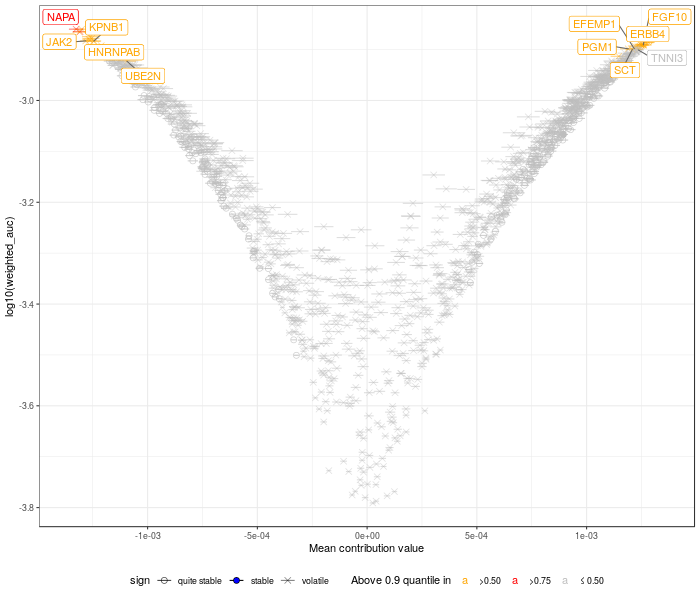

In [30]:
%%R -w 700 -h 600  -i joint_o2pls_contribs_protein

g = coefficients_volcano_plot(
    joint_o2pls_contribs_protein,
    n=15, p_value='weighted_auc', neg=F,
    quite_stable_alpha=0.75, volatile_alpha=0.5,
    highlight_frequent=0.5, frequency='above_abs_iteration_quantile_0.9',
    frequency_title='Above 0.9 quantile in',
    highlight_top=TRUE
) + ylab('Mean contribution value')

g

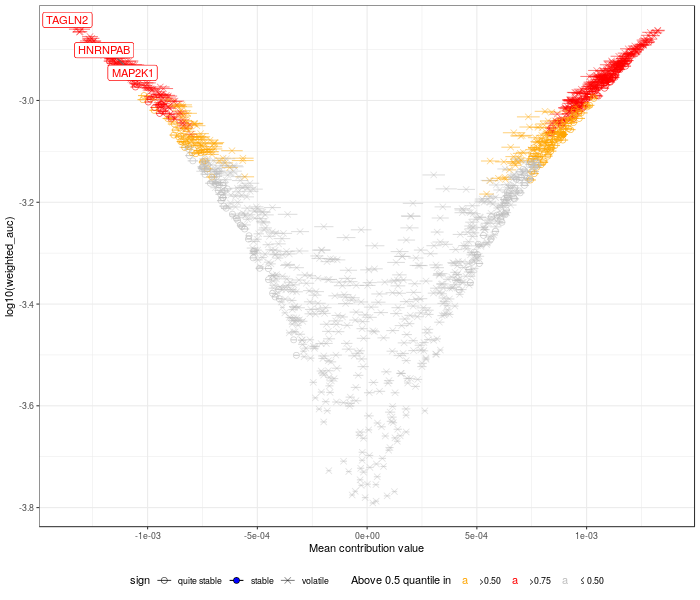

In [31]:
%%R -w 700 -h 600  -i joint_o2pls_contribs_protein

g = coefficients_volcano_plot(
    joint_o2pls_contribs_protein,
    n=15, p_value='weighted_auc', neg=F,
    quite_stable_alpha=0.75, volatile_alpha=0.5,
    highlight_frequent=0.99, frequency='above_abs_iteration_quantile_0.5',
    frequency_title='Above 0.5 quantile in',
    highlight_top=TRUE
) + ylab('Mean contribution value')

g

In [32]:
%%R
zoom = coefficients_volcano_plot(
    joint_o2pls_contribs_protein,
    n=15, p_value='weighted_auc', neg=F,
    quite_stable_alpha=0.75, volatile_alpha=0.5,
    highlight_frequent=0.99, frequency='above_abs_iteration_quantile_0.5',
    frequency_title='Above 0.5 quantile in',
    highlight_top=TRUE, errorbar_alpha=0.2, box_padding=0.5
) + ylab('Mean contribution value')

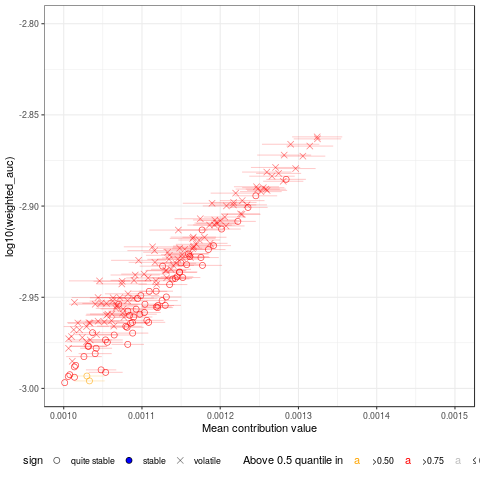

In [33]:
%%R
zoom + ylim(0.001, 0.0015) + xlim(-3, -2.8)

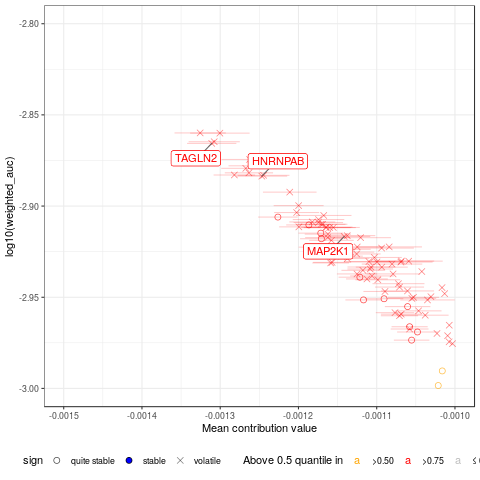

In [34]:
%%R
zoom + ylim(-0.0015, -0.001) + xlim(-3, -2.8)

In [35]:
protein_full.T.loc['GPC2'].groupby(protein_full_groups).mean()

Cryptococcal            -0.415220
Definite tuberculosis   -0.810611
Healthy control          0.852763
Possible tuberculosis   -0.055144
Probable tuberculosis   -0.405677
Viral                    0.336394
Name: GPC2, dtype: float64

In [36]:
joint_o2pls.cross_validation.contributions.y.add_hdi_significance(
    joint_o2pls.training_dataset.y,
    joint_o2pls.training_dataset.binary_response,
    family='gaussian'
)

Loading required package: scalreg
Loading required package: lars
Loaded lars 1.2

Nodewise regressions will be computed as no argument Z was provided.
You can store Z to avoid the majority of the computation next time around.
Z only depends on the design matrix x.


In [37]:
joint_o2pls_contribs_protein.sort_values('above_abs_iteration_quantile_0.9')

,mean,selected_in,positive_in,negative_in,volatile,...,weighted_auc,above_abs_iteration_quantile_0.5,above_abs_iteration_quantile_0.9,gaussian_p,gaussian_FDR
STUB1,-0.000677,1.0,0.06,0.94,0.12,...,0.000719,0.46,0.00,0.565845,0.965789
CEBPB,-0.000436,1.0,0.06,0.94,0.12,...,0.000509,0.27,0.00,0.392575,0.965789
SMAD3,-0.000780,1.0,0.05,0.95,0.10,...,0.000838,0.66,0.00,0.531501,0.965789
IL23A,0.000153,1.0,0.64,0.36,0.72,...,0.000291,0.04,0.00,0.793113,0.965789
IL12B,0.000178,1.0,0.66,0.34,0.68,...,0.000308,0.06,0.00,0.797734,0.965789
...,...,...,...,...,...,...,...,...,...,...,...
TAGLN2,-0.001311,1.0,0.06,0.94,0.12,...,0.001363,0.99,0.74,0.435244,0.965789
PTEN,0.001324,1.0,0.94,0.06,0.12,...,0.001374,0.98,0.75,0.947685,0.989496
NAPA,-0.001326,1.0,0.06,0.94,0.12,...,0.001381,0.98,0.77,0.325850,0.965789
HSPA8,-0.001308,1.0,0.06,0.94,0.12,...,0.001365,0.98,0.80,0.286927,0.965789


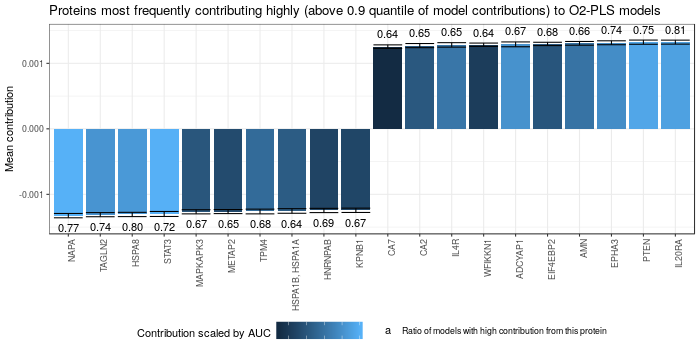

In [38]:
%%R -i joint_o2pls_contribs_protein -w 700 -h 350
(
    plots_most_frequently_included(
        joint_o2pls_contribs_protein, n=20, label_margin=0.0001,
        frequency='above_abs_iteration_quantile_0.9',
        fill='weighted_auc',
        fill_name='Contribution scaled by AUC',
        #label='gaussian_p',
        label_name='Ratio of models with high contribution from this protein', type='contribution'
    )
    + xlab('Protein')
    + ggtitle(
        'Proteins most frequently contributing highly (above 0.9 quantile of model contributions) to O2-PLS models'
    )
    + guides(
        fill=guide_colourbar(label=FALSE, order=1)
    )
    + theme(
        legend.margin=margin(b=0, unit='cm'),
        axis.title.x=element_blank()
    )
)

Compare with the list of https://www.hindawi.com/journals/mi/2019/7582948/:
 - IFN-γ, MIP-4, CXCL9, CCL1, RANTES, IL-6, TNF-α, MPO, MMP-9, MMP-8, CC2, IL-10, PAI-1, CXCL8, IL-1b, A1AT, CXCL10, G-CSF, CC4, CC4b, GM-CSF, PDGF AB/BB, Apo-AI, MBL, ferritin, CC5a, SAP, and CC5

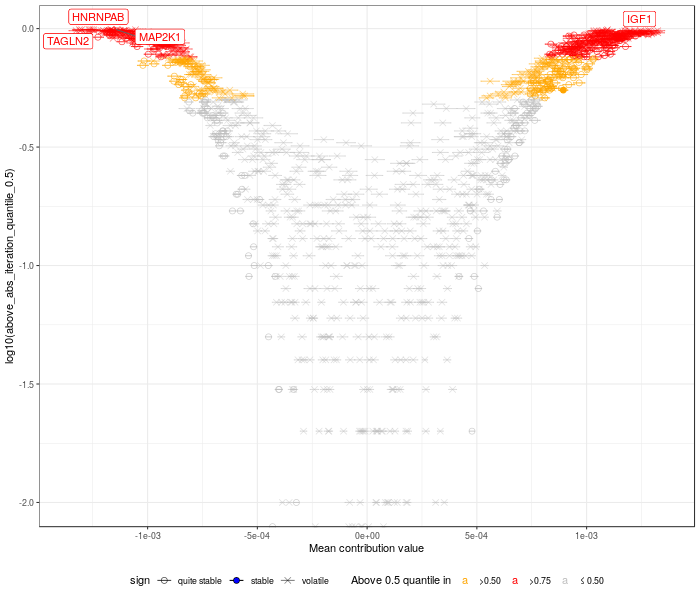

In [39]:
%%R -w 700 -h 600  -i joint_o2pls_contribs_protein

coefficients_volcano_plot(
    joint_o2pls_contribs_protein,
    n=15, p_value='above_abs_iteration_quantile_0.5', neg=F,
    quite_stable_alpha=0.75, volatile_alpha=0.5,
    highlight_frequent=0.99, frequency='above_abs_iteration_quantile_0.5',
    frequency_title='Above 0.5 quantile in',
    highlight_top=TRUE
) + ylab('Mean contribution value')

### Enrichment

In [40]:
import analyses.integration.Pathway_enrichment
%R import::here(camera_pr, .from='helpers/pathways.R')

Importing Jupyter notebook from /home/krassowski/meningitis/code/analyses/integration/Pathway_enrichment.ipynb
hallmarks 50
hallmarks_for_rna 50
hallmarks_for_protein 49
reactome 1401
reactome_for_rna 1401
reactome_for_protein 570


General picture of meningitis, not related to disease etiology and indifferent to the method in use, as discoverable when using observed subset of transcripts/proteins:

In [41]:
%R camera_pr(joint_o2pls_contribs_protein, 'mean_abundance', hallmarks_for_protein)

,NGenes,Direction,PValue,FDR
NOTCH SIGNALING,7.0,Up,0.001514,0.074187
WNT BETA CATENIN SIGNALING,8.0,Up,0.019535,0.444772
MTORC1 SIGNALING,32.0,Up,0.027231,0.444772
KRAS SIGNALING UP,53.0,Up,0.113112,0.878332
ANDROGEN RESPONSE,10.0,Up,0.157227,0.878332
...,...,...,...,...
IL6 JAK STAT3 SIGNALING,60.0,Up,0.806632,0.878332
HEDGEHOG SIGNALING,9.0,Up,0.906285,0.965390
EPITHELIAL MESENCHYMAL TRANSITION,71.0,Up,0.933775,0.971609
APICAL JUNCTION,43.0,Up,0.951780,0.971609


In [42]:
%R camera_pr(joint_o2pls_contribs_rna, 'mean_abundance', hallmarks_for_rna)

,NGenes,Direction,PValue,FDR
ANDROGEN RESPONSE,98.0,Up,0.000677,0.033839
DNA REPAIR,150.0,Up,0.007638,0.190939
HEME METABOLISM,185.0,Up,0.030653,0.510885
PI3K AKT MTOR SIGNALING,101.0,Up,0.057827,0.722843
PROTEIN SECRETION,95.0,Up,0.083911,0.765015
...,...,...,...,...
ESTROGEN RESPONSE LATE,191.0,Up,0.903036,0.932451
MYC TARGETS V1,198.0,Down,0.904275,0.932451
HYPOXIA,194.0,Down,0.904737,0.932451
ALLOGRAFT REJECTION,191.0,Down,0.913802,0.932451


Naive group differences (should not be taken too seriously, the difference metric is known to be weak), supervised:

In [43]:
def get_diff(data, group_a, group_b, func=lambda a, b: a - b):
    a = data[data.index.str.contains(group_a)].mean()
    b = data[data.index.str.contains(group_b)].mean()
    return func(a, b).to_frame('diff')

In [44]:
protein_diff = get_diff(protein_full, 'TMD|TMR', 'CM')
rna_diff = get_diff(rna_full, 'TMD|TMR', 'CM')
protein_diff.head()

,diff
STUB1,0.629198
CEBPB,0.596850
ENO2,-0.478050
PIAS4,0.433054
IL10RA,-0.731442


In [45]:
%R -i protein_diff -i rna_diff

In [46]:
%%R
protein = head(camera_pr(protein_diff, 'diff', hallmarks_for_protein), 10)
RNA = head(camera_pr(rna_diff, 'diff', hallmarks_for_rna), 10)
o2pls = head(camera_pr(joint_o2pls_contribs_protein, 'mean', hallmarks_for_protein), 10)

RNA$gene = rownames(RNA)
RNA$kind = 'RNA'
RNA$from = 'RNA'

protein$gene = rownames(protein)
protein$kind = 'Protein'
protein$from = 'Protein'

o2pls$gene = rownames(o2pls)
o2pls$kind = 'Mean of contributions O2-PLS (proteins)'
o2pls$from = ifelse(
    rownames(o2pls) %in% rownames(RNA) & rownames(o2pls) %in% rownames(protein),
    'Both',
    ifelse(
        rownames(o2pls) %in% rownames(RNA),
        'RNA',
        ifelse(rownames(o2pls) %in% rownames(protein), 'Protein', 'Neither')
    )
)

df = rbind(protein, RNA, o2pls)
df$kind = factor(df$kind, levels=c('RNA', 'Protein', 'Mean of contributions O2-PLS (proteins)'))

In [47]:
%%R
brewer.pal(5, 'Dark2')

[1] "#1B9E77" "#D95F02" "#7570B3" "#E7298A" "#66A61E"


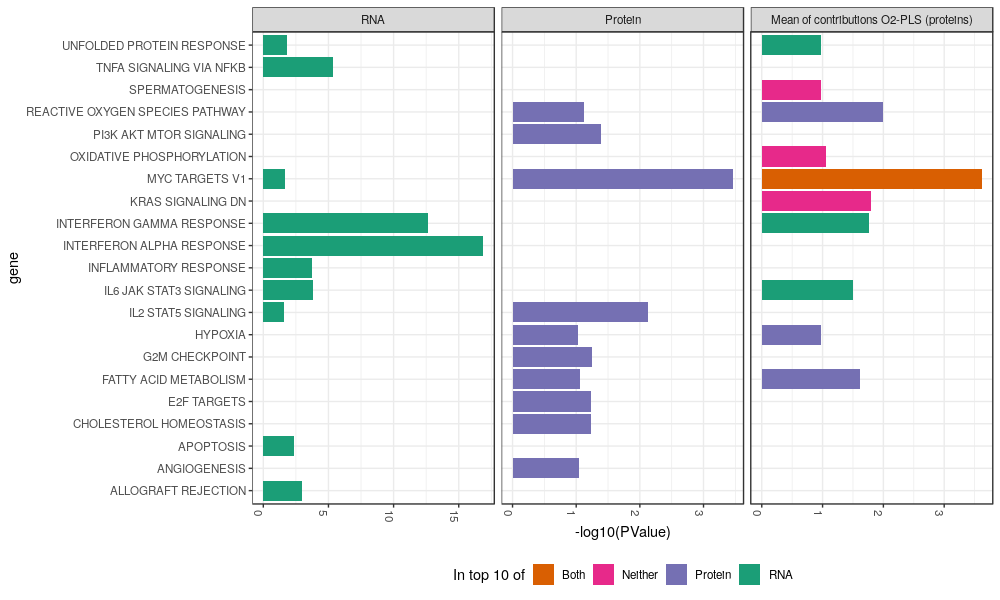

In [48]:
%%R -w 1000 -r 95 -h 600
library(RColorBrewer)
(
    ggplot(df, aes(x=gene, y=-log10(PValue), fill=from))
    + geom_bar(stat='identity')
    + facet_wrap('kind', scale='free_x')
    + nice_theme
    + theme(axis.text.x=element_text(angle = -90, hjust = 0))
    + coord_flip()
    + scale_fill_manual(name='In top 10 of', values=c('#D95F02', '#E7298A', '#7570B3', '#1B9E77'))
)

In [49]:
%R head(camera_pr(joint_o2pls_contribs_protein, 'mean', reactome_for_protein), 10)

,NGenes,Direction,PValue,FDR
Diseases of glycosylation,27.0,Up,0.000235,0.093281
Cellular responses to external stimuli,71.0,Down,0.000581,0.093281
Signaling by RAS mutants,17.0,Down,0.000974,0.093281
Oncogenic MAPK signaling,17.0,Down,0.000974,0.093281
Signaling by VEGF,35.0,Down,0.001055,0.093281
Signaling by BRAF and RAF fusions,16.0,Down,0.001146,0.093281
Signaling by moderate kinase activity BRAF mutants,16.0,Down,0.001146,0.093281
Fcgamma receptor (FCGR) dependent phagocytosis,23.0,Down,0.001725,0.097789
Cellular responses to stress,66.0,Down,0.001840,0.097789
RAF activation,9.0,Down,0.001885,0.097789


In [50]:
%R head(camera_pr(joint_o2pls_contribs_protein, 'weighted_auc', reactome_for_protein), 10)

,NGenes,Direction,PValue,FDR
Growth hormone receptor signaling,12.0,Up,0.002722,0.550047
Signaling by NTRKs,30.0,Up,0.004349,0.550047
Activation of the AP-1 family of transcription factors,7.0,Up,0.004584,0.550047
Signaling by NTRK1 (TRKA),23.0,Up,0.005222,0.550047
RHO GTPases Activate WASPs and WAVEs,8.0,Up,0.006240,0.550047
Interleukin-20 family signaling,15.0,Up,0.007032,0.550047
Signal attenuation,6.0,Up,0.008896,0.550047
Interleukin-6 signaling,8.0,Up,0.009406,0.550047
RAF-independent MAPK1/3 activation,11.0,Up,0.009700,0.550047
Interleukin-6 family signaling,14.0,Up,0.012098,0.550047


#### RNA

In [51]:
%R head(camera_pr(joint_o2pls_contribs_rna, 'mean', reactome_for_rna), 10)

,NGenes,Direction,PValue,FDR
Neutrophil degranulation,458.0,Down,3.853475e-15,5.398719e-12
Interleukin-10 signaling,44.0,Down,4.447724e-13,3.115631e-10
Transcriptional Regulation Of Granulopoiesis,83.0,Down,3.310360e-11,1.545938e-08
Pre-NOTCH Expression and Processing,102.0,Down,2.131333e-09,7.464993e-07
Diseases of Immune System,24.0,Down,6.971613e-09,1.953446e-06
DNA methylation,57.0,Down,1.056358e-08,2.466596e-06
Senescence-Associated Secretory Phenotype (SASP),102.0,Down,2.475877e-08,4.955290e-06
SIRT1 negatively regulates rRNA expression,61.0,Down,3.440724e-08,6.025568e-06
Toll Like Receptor 4 (TLR4) Cascade,125.0,Down,5.235180e-08,8.149430e-06
Toll-like Receptor Cascades,150.0,Down,6.806567e-08,9.536001e-06


In [52]:
%R head(camera_pr(joint_o2pls_contribs_rna, 'weighted_auc', reactome_for_rna), 10)

,NGenes,Direction,PValue,FDR
Interleukin-10 signaling,44.0,Up,2.048278e-11,2.869637e-08
Neutrophil degranulation,458.0,Up,1.012774e-08,7.094485e-06
Interleukin-4 and Interleukin-13 signaling,103.0,Up,2.661049e-07,1.242710e-04
Diseases of Immune System,24.0,Up,8.392190e-07,2.939365e-04
Biosynthesis of EPA-derived SPMs,6.0,Up,1.816229e-06,4.608918e-04
Synthesis of 5-eicosatetraenoic acids,8.0,Up,1.973841e-06,4.608918e-04
p75NTR signals via NF-kB,16.0,Up,2.555652e-05,5.114956e-03
TAK1 activates NFkB by phosphorylation and activation of IKKs complex,31.0,Up,4.521473e-05,7.593745e-03
Biosynthesis of specialized proresolving mediators (SPMs),18.0,Up,4.878209e-05,7.593745e-03
Interleukin-1 processing,8.0,Up,6.407609e-05,8.977061e-03


## Scratchpad and ideas for future research

- Pathways enrichment might be more meaningful with Ridge regularization
- Random forest would be another very simple but potentially useful classifier
- Group LASSO may solve the issue of multi-collinearity, there is an sklearn-API for it: https://pypi.org/project/group-lasso/